In [1]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoConfig
import pandas as pd
import matplotlib.pyplot as plt
import os


/opt/homebrew/Caskroom/miniconda/base/envs/biostat-fitness/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%script false

import numpy as np
from scipy.stats import norm, gaussian_kde, entropy

## Finding nicest dataset
score_collection = []
for file in [x for x in os.listdir("data/processed_data/") if x not in [".DS_Store", "README.md"]]:
    path = f"data/processed_data/{file}/data.csv"
    # save figure
    print(path)
    plt.title(file)
    pd.read_csv(path)["log_fitness"].hist()
    plt.savefig(f"output/misc/{file}.jpg")
    plt.clf()

    data = pd.read_csv(path)["log_fitness"]

    mu, sigma = np.mean(data), np.std(data)
    kde = gaussian_kde(data)

    # Evaluate on a fine grid
    xs = np.linspace(data.min(), data.max(), 500)
    p = kde(xs)
    q = norm(loc=mu, scale=sigma).pdf(xs)

    # Normalize to ensure both are proper distributions
    p /= np.trapezoid(p, xs)
    q /= np.trapezoid(q, xs)

    kl_value = np.trapezoid(p * np.log(p / q), xs)

    score_collection.append((kl_value, path))
    # print(f'(kl-gauss) score: {kl_value}, path: {path}')

# Note - (most gaussian) dataset:  UBE4B_MOUSE_Klevit2013-nscor_log2_ratio
print()
print("best pair: ", min(score_collection, key=lambda x: x[0]))
print("array: ", np.array([x[0] for x in score_collection]))
print("std: ", np.array([x[0] for x in score_collection]).std())


# nicer metrics
# look into kmers + richer embeddings

# Q
# - should I use MAE or RMSE how to pick one (MAE - linear but more robus, RMSE - aligns with GPR assumption)
# - or should I use spearman/tau -> bc don't we actually care about ordering/rank more than precise viability values (we care about relative)

data/processed_data/UBE4B_MOUSE_Klevit2013-nscor_log2_ratio/data.csv
data/processed_data/GAL4_YEAST_Shendure2015-SEL_C_40h/data.csv
data/processed_data/BRCA1_HUMAN_Fields2015-e3/data.csv
data/processed_data/BLAT_ECOLX_Ostermeier2014-linear/data.csv
data/processed_data/YAP1_HUMAN_Fields2012-singles-linear/data.csv
data/processed_data/GFP_AEQVI_Sarkisyan2016/data.csv
data/processed_data/MTH3_HAEAESTABILIZED_Tawfik2015-Wrel_G17_filtered/data.csv
data/processed_data/PABP_YEAST_Fields2013-linear/data.csv
data/processed_data/DLG4_RAT_Ranganathan2012-CRIPT/data.csv
data/processed_data/BLAT_ECOLX_Tenaillon2013-singles-MIC_score/data.csv
data/processed_data/BLAT_ECOLX_Palzkill2012-ddG_stat/data.csv
data/processed_data/RL401_YEAST_Bolon2014-react_rel/data.csv
data/processed_data/RL401_YEAST_Bolon2013-selection_coefficient/data.csv
data/processed_data/BG_STRSQ_Abate2015-enrichment/data.csv
data/processed_data/KKA2_KLEPN_Mikkelsen2014-Kan18_avg/data.csv
data/processed_data/BLAT_ECOLX_Ranganathan20

<Figure size 640x480 with 0 Axes>

In [23]:
#esm2_t6_8M_UR50D -> R^320 embeddings

esm_config = AutoConfig.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

df = pd.read_csv("data/processed_data/UBE4B_MOUSE_Klevit2013-nscor_log2_ratio/data.csv")
df = df.rename(columns={"seq": "sequence", "log_fitness": "viability"})

print(esm_config)
print(df.shape)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmConfig {
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "dtype": "float32",
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 320,
  "initializer_range": 0.02,
  "intermediate_size": 1280,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "transformers_version": "4.56.0",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}

(32290, 3)


In [54]:
embedding_file = "cache/embeddings.pt"

if os.path.exists(embedding_file):
    X = torch.load(embedding_file)
else:
    embeddings = []
    with torch.no_grad():
        for seq in df["sequence"]:
            tokenized_input = esm_tokenizer(seq, return_tensors="pt")
            output = esm_model(**tokenized_input)
            seq_embedding = output.last_hidden_state.mean(dim=1).squeeze()
            embeddings.append(seq_embedding)

    X = torch.stack(embeddings)
    torch.save(X, embedding_file)

# Embedding-dim = 320

X = torch.load(embedding_file)
y = torch.tensor(df["viability"].values, dtype=torch.float32)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=80)
# X = pca.fit_transform(X.numpy())
# print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

Explained variance ratio: 0.97216547


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)


# # i know this is stupid -> altnerative block is better but throws warning
# X_train_tensor = torch.tensor(X_train.numpy(), dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.numpy(), dtype=torch.float32)
# X_test_tensor = torch.tensor(X_train.numpy(), dtype=torch.float32)
# y_test_tensor = torch.tensor(y_train.numpy(), dtype=torch.float32)

# throws warrning but more efficient
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([25832, 80])
torch.Size([25832])
torch.Size([6458, 80])
torch.Size([6458])


/var/folders/v0/tllws09j6qnc4kds9pv97y6r0000gn/T/ipykernel_1821/1366589518.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
/var/folders/v0/tllws09j6qnc4kds9pv97y6r0000gn/T/ipykernel_1821/1366589518.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [46]:
import gpytorch
import torch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = ExactGPModel(X_train_tensor, y_train_tensor, likelihood)

In [47]:
gp_model.train()
likelihood.train()

optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

training_iterations = 100
for i in range(training_iterations):
    optimizer.zero_grad()
    output = gp_model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Itmer {i+1}/{training_iterations} - Loss: {loss.item():.4f}")

Iter 1/100 - Loss: 2.9990
Iter 11/100 - Loss: 2.1061
Iter 21/100 - Loss: 1.9011
Iter 31/100 - Loss: 1.9381
Iter 41/100 - Loss: 1.9035
Iter 51/100 - Loss: 1.8944
Iter 61/100 - Loss: 1.8924
Iter 71/100 - Loss: 1.8948
Iter 81/100 - Loss: 1.8907
Iter 91/100 - Loss: 1.8868


In [51]:
## metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from scipy.stats import kendalltau

gp_model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_predictions = likelihood(gp_model(X_test_tensor))
    test_means = test_predictions.mean.numpy()

mae = mean_absolute_error(y_test, test_means)
mse = mean_squared_error(y_test, test_means)
rmse = np.sqrt(mse)
tau, p_value = kendalltau(y_test, test_means)

print(f"MAE: {mae}")  # robust to outliers
print(f"MSE: {mse}")
print(f"\033[1mRMSE: {rmse}\033[0m")  # aligns with GPR assumptions
print(f"\033[1mKendall's Tau: {tau} (p-value: {p_value})\033[0m")  # rank correlation [-1, 1] + probability of observing this Tau given H_0 (random ordering)

MAE: 1.2374489307403564
MSE: 2.553964376449585
RMSE: 1.598112754610758
Kendall's Tau: 0.41676714590309194 (p-value: 0.0)


/var/folders/v0/tllws09j6qnc4kds9pv97y6r0000gn/T/ipykernel_1821/2359450642.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals = y_test - test_means


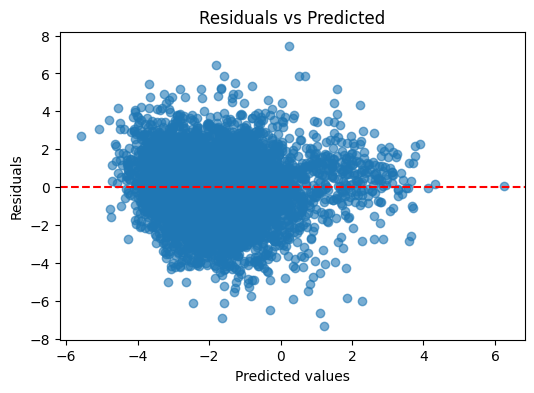

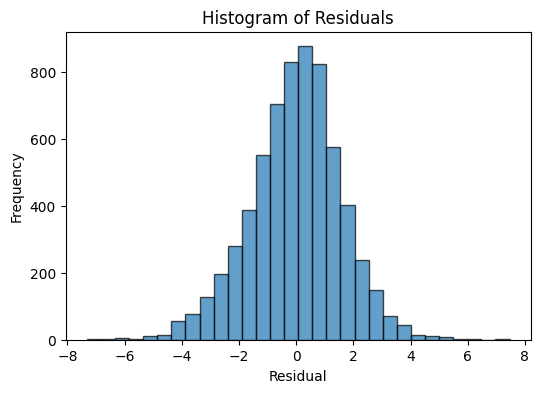

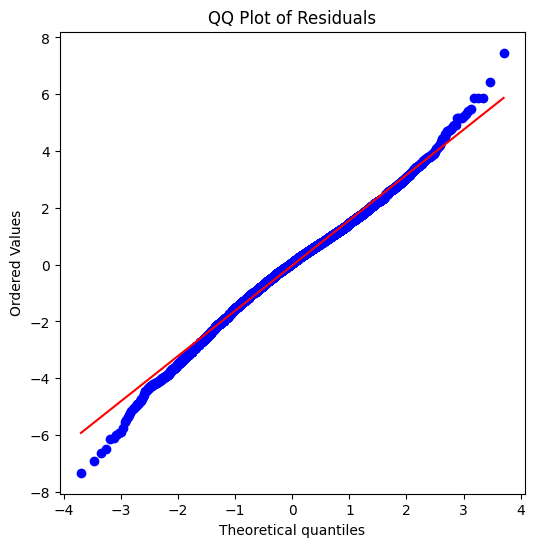

In [52]:
## residual plots

import matplotlib.pyplot as plt
import numpy as np

residuals = y_test - test_means

# 1. Residuals vs Predicted
plt.figure(figsize=(6, 4))
plt.scatter(test_means, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='k')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# 3. QQ-plot of residuals (normality check)
import scipy.stats as stats
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

# 4. Residuals vs each predictor (for multivariable regression)
if X_test_tensor.shape[1] <= 5:  # avoid plotting too many features
    X_test_np = X_test_tensor.numpy()
    for i in range(X_test_np.shape[1]):
        plt.figure(figsize=(6, 4))
        plt.scatter(X_test_np[:, i], residuals, alpha=0.6)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel(f"Feature {i}")
        plt.ylabel("Residuals")
        plt.title(f"Residuals vs Feature {i}")
        plt.show()


In [53]:
## validate arbitrary training point
train_x = X_train_tensor[0].unsqueeze(0)
true_viability = y_train_tensor[0].item()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(gp_model(train_x))
    predicted_mean = observed_pred.mean.item()
    lower_bound, upper_bound = observed_pred.confidence_region()

print(f"True Viability: {true_viability}")
print(f"Predicted Viability: {predicted_mean}")
print(f"95% CI: [{lower_bound.item()}, {upper_bound.item()}]")

True Viability: -3.128000020980835
Predicted Viability: -2.582655668258667
95% CI: [-6.551504611968994, 1.3861932754516602]
